In [4]:
import yaml
import pickle
from pathlib import Path

import pandas as pd
from tqdm import tqdm
from datetime import datetime

from reservoirs_lshm import Config, read_attributes, read_timeseries
from reservoirs_lshm.models import get_model
from reservoirs_lshm.calibration import get_calibrator, read_results
from reservoirs_lshm.utils.metrics import KGEmod, compute_performance
from reservoirs_lshm.utils.timeseries import create_demand
from reservoirs_lshm.utils.logging import setup_logger

In [11]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
path = Path('/home/chus-casado/Datos/reservoirs/ResOpsUS/v2.2/results')

grand_id = 355

## CaMa-Flood

In [44]:
config_file = path / 'camaflood' / 'camaflood_2var_5par.yml'

cfg = Config(config_file)

# reservoirs = pd.read_csv(cfg.RESERVOIRS_FILE, header=None).squeeze().tolist()
reservoirs = [355]

attributes = read_attributes(cfg.PATH_DATA / 'attributes', reservoirs)

with open(cfg.PERIODS_FILE, 'rb') as file:
    periods = pickle.load(file)

inputs = [var for var in [cfg.INFLOW, cfg.PRECIPITATION, cfg.EVAPORATION, cfg.DEMAND] if var]
outputs = ['storage', 'outflow']
timeseries = read_timeseries(
    path=cfg.PATH_DATA / 'time_series' / 'csv',
    reservoirs=attributes.index,
    periods=periods,
    variables=inputs + outputs
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
for grand_id, ts in timeseries.items():
    break

In [46]:
# dbname = f'{cfg.PATH_CALIB}/{grand_id}_samples'
dbname = path / cfg.MODEL / 'calibration' / '5par' / 'bivariate' / f'{grand_id}_samples'

# define input time series
inflow = ts[cfg.INFLOW]
precipitation = ts[cfg.PRECIPITATION] if cfg.PRECIPITATION in ts.columns else None
evaporation = ts[cfg.EVAPORATION] if cfg.EVAPORATION in ts.columns else None
demand = ts[cfg.DEMAND] if cfg.DEMAND in ts.columns else None
if cfg.MODEL == 'mhm':
    bias = ts.outflow.mean() / inflow.mean()
    demand = create_demand(
        ts.outflow,
        water_stress=min(1, bias),
        window=28
    )
    
# storage attributes (m3)
Vtot = max(attributes.loc[grand_id, 'CAP_MCM'].item() * 1e6, ts.storage.max())
# Vtot = ts.storage.max()
Vmin = max(0, min(0.1 * Vtot, ts.storage.min()))
# flow attributes (m3/s)
Qmin = max(0, ts.outflow.min())
# catchment area (m2)
catchment = int(attributes.loc[grand_id, 'CATCH_SKM'].item() * 1e6) if cfg.MODEL == 'camaflood' else None
# reservoir area (m2)
Atot = int(attributes.loc[grand_id, 'AREA_SKM'].item() * 1e6)

# configure calibration kwargs
cal_cfg = {}
if cfg.MODEL == 'camaflood':
    cal_cfg.update({'catchment': catchment})
# elif cfg.MODEL == 'mhm':
#     cal_cfg.update({'demand': demand})
# initialize the calibration setup
calibrator = get_calibrator(
    cfg.MODEL,
    parameters=cfg.PARAMETERS,
    inflow=inflow,
    storage=ts.storage,
    outflow=ts.outflow,
    precipitation=precipitation,
    evaporation=evaporation,
    demand=demand,
    Vmin=Vmin,
    Vtot=Vtot,
    Qmin=Qmin,
    Atot=Atot,
    target=cfg.TARGET,
    obj_func=KGEmod,
    spinup=cfg.SPINUP,
    **cal_cfg
)

# read calibration results
results, parameters = read_results(f'{dbname}.csv')

# convert parameter into reservoir attributes
calibrated_attrs = calibrator.pars2attrs(list(parameters.values()))

# declare the reservoir with optimal parameters
camaflood = get_model(cfg.MODEL, **calibrated_attrs)

In [75]:
def plot_camaflood(reservoir, timeseries, ax=None, **kwargs):

    lw = kwargs.get('lw', 1.2)
    figsize = kwargs.get('figsize', (4, 4))

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    V = np.array([0, reservoir.Vmin])
    Q = V / reservoir.Vf * reservoir.Qn
    ax.plot(V * 1e-6, Q, lw=lw, c='steelblue')
    
    V = np.linspace(reservoir.Vmin, reservoir.Ve, 100)
    Q = reservoir.Vmin / reservoir.Vf * reservoir.Qn + ((V - reservoir.Vmin) / (reservoir.Ve - reservoir.Vmin))**2 * (reservoir.Qf - reservoir.Vmin / reservoir.Vf * reservoir.Qn)
    ax.plot(V * 1e-6, Q, lw=lw, c='steelblue', label=r'$I < Q_f$')
    
    V = np.linspace(reservoir.Vmin, reservoir.Vf, 100)
    Q = reservoir.Vmin / reservoir.Vf * reservoir.Qn + (V - reservoir.Vmin) / (reservoir.Vf - reservoir.Vmin) * (reservoir.Qf - reservoir.Vmin / reservoir.Vf * reservoir.Qn)
    ax.plot(V * 1e-6, Q, lw=lw, c='indianred', label=r'$I ≥ Q_f$')
    
    V = np.linspace(reservoir.Vf, reservoir.Ve, 100)
    k = max(1 - (reservoir.Vtot - reservoir.Vf) / (reservoir.catchment * .2), 0)
    I = 1.5 * reservoir.Qf
    Q = reservoir.Qf + k * (V - reservoir.Vf) / (reservoir.Ve - reservoir.Vf) * (I - reservoir.Qf)
    ax.plot(V * 1e-6, Q, lw=lw, c='indianred')
    
    ax.scatter(ts.storage * 1e-6, ts.outflow, marker='.', s=.5, color='lightgrey', alpha=.5, zorder=0)
    #mask = ts.inflow > reservoir.Qf
    #ax.scatter(ts[~mask].storage * 1e-6, ts[~mask].outflow, marker='.', s=.5, color='lightgrey', alpha=.5, zorder=0)
    #ax.scatter(ts[mask].storage * 1e-6, ts[mask].outflow, marker='.', s=.5, color='indianred', alpha=.5, zorder=0)
    
    # reference storages and outflows
    vs = [reservoir.Vmin, reservoir.Vf, reservoir.Ve]
    qs = [reservoir.Vmin / reservoir.Vf * reservoir.Qn, reservoir.Qf, reservoir.Qf]
    for v, q in zip(vs, qs):
        ax.vlines(v * 1e-6, 0, q, color='k', ls=':', lw=.5, zorder=0)
        ax.hlines(q, 0, v * 1e-6, color='k', ls=':', lw=.5, zorder=0)
    
    # labels
    ax.text(0, qs[0], r'$\frac{V_c}{V_f} Q_n$', ha='left', va='bottom')
    ax.text(0, qs[1], r'$Q_f$', ha='left', va='bottom')
    ax.text(reservoir.Vmin * 1e-6, 0, r'$V_c$', rotation=90, ha='left', va='bottom')
    ax.text(reservoir.Vf * 1e-6, 0, r'$V_f$', rotation=90, ha='right', va='bottom')
    ax.text(reservoir.Ve * 1e-6, 0, r'$V_e$', rotation=90, ha='right', va='bottom')
    
    ax.set(
        xlim=(0, reservoir.Vtot * 1e-6),
        xlabel=kwargs.get('xlabel', 'storage (hm3)'),
        ylim=(0, None),
        ylabel=kwargs.get('ylabel', 'outflow (m3/s)'),
        title=kwargs.get('title', None)
    )
    ax.legend(frameon=False)

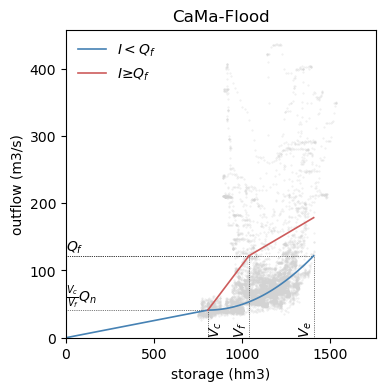

In [77]:
plot_camaflood(camaflood, ts, title='CaMa-Flood')

## LISFLOOD

In [13]:
config_file = path / 'lisflood' / 'lisflood_2var_6par.yml'

cfg = Config(config_file)

In [14]:
# dbname = f'{cfg.PATH_CALIB}/{grand_id}_samples'
dbname = path / cfg.MODEL / 'calibration' / '6par' / 'bivariate' / f'{grand_id}_samples'

# define input time series
inflow = ts[cfg.INFLOW]
precipitation = ts[cfg.PRECIPITATION] if cfg.PRECIPITATION in ts.columns else None
evaporation = ts[cfg.EVAPORATION] if cfg.EVAPORATION in ts.columns else None
demand = ts[cfg.DEMAND] if cfg.DEMAND in ts.columns else None
if cfg.MODEL == 'mhm':
    bias = ts.outflow.mean() / inflow.mean()
    demand = create_demand(
        ts.outflow,
        water_stress=min(1, bias),
        window=28
    )
    
# storage attributes (m3)
Vtot = max(attributes.loc[grand_id, 'CAP_MCM'].item() * 1e6, ts.storage.max())
# Vtot = ts.storage.max()
Vmin = max(0, min(0.1 * Vtot, ts.storage.min()))
# flow attributes (m3/s)
Qmin = max(0, ts.outflow.min())
# catchment area (m2)
catchment = int(attributes.loc[grand_id, 'CATCH_SKM'].item() * 1e6) if cfg.MODEL == 'camaflood' else None
# reservoir area (m2)
Atot = int(attributes.loc[grand_id, 'AREA_SKM'].item() * 1e6)

# configure calibration kwargs
cal_cfg = {}
if cfg.MODEL == 'camaflood':
    cal_cfg.update({'catchment': catchment})
# elif cfg.MODEL == 'mhm':
#     cal_cfg.update({'demand': demand})
# initialize the calibration setup
calibrator = get_calibrator(
    cfg.MODEL,
    parameters=cfg.PARAMETERS,
    inflow=inflow,
    storage=ts.storage,
    outflow=ts.outflow,
    precipitation=precipitation,
    evaporation=evaporation,
    demand=demand,
    Vmin=Vmin,
    Vtot=Vtot,
    Qmin=Qmin,
    Atot=Atot,
    target=cfg.TARGET,
    obj_func=KGEmod,
    spinup=cfg.SPINUP,
    **cal_cfg
)

# read calibration results
results, parameters = read_results(f'{dbname}.csv')

# convert parameter into reservoir attributes
calibrated_attrs = calibrator.pars2attrs(list(parameters.values()))

# declare the reservoir with optimal parameters
lisflood = get_model(cfg.MODEL, **calibrated_attrs)

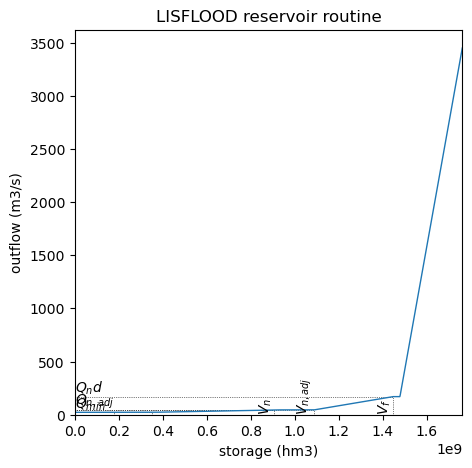

In [15]:
lisflood.plot_routine()

In [79]:
def plot_lisflood(reservoir, timeseries, ax=None, **kwargs):

    lw = kwargs.get('lw', 1.2)
    c = kwargs.get('c', 'steelblue')
    figsize = kwargs.get('figsize', (4, 4))

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    V = np.array([0, 2 * reservoir.Vmin])
    Q = np.zeros_like(V) + reservoir.Qmin
    ax.plot(V * 1e-6, Q, lw=lw, c='steelblue')
    
    V = np.linspace(2 * reservoir.Vmin, reservoir.Vn, 100)
    Q = reservoir.Qmin + (reservoir.Qn - reservoir.Qmin) * (V - 2 * reservoir.Vmin) / (reservoir.Vn - 2 * reservoir.Vmin)
    ax.plot(V * 1e-6, Q, lw=lw, c=c)
    
    V = np.linspace(reservoir.Vn, reservoir.Vn_adj, 100)
    Q = np.zeros_like(V) + reservoir.Qn
    ax.plot(V * 1e-6, Q, lw=lw, c=c)
    
    V = np.linspace(reservoir.Vn_adj, reservoir.Vf, 100)
    Q = reservoir.Qn + (reservoir.Qf - reservoir.Qn) * (V - reservoir.Vn_adj) / (reservoir.Vf - reservoir.Vn_adj)
    #if Q > reservoir.k * I:
    #    Q = np.max([reservoir.k * I, reservoir.Qn])
    ax.plot(V * 1e-6, Q, lw=lw, c=c)
    
    #V = np.linspace(reservoir.Vf, reservoir.Vtot, 100)
    #I = 1.1 * reservoir.Qf
    #Q = np.maximum((V - reservoir.Vf) / reservoir.timestep, np.min([reservoir.Qf, np.max([reservoir.k * I, reservoir.Qn])]))
    #ax.plot(V * 1e-6, Q, lw=lw, c=c)
    
    ax.scatter(timeseries.storage * 1e-6, timeseries.outflow, marker='.', s=.5, color='lightgrey', alpha=.5, zorder=0)
    
    # reference storages and outflows
    vs = [2 * reservoir.Vmin, reservoir.Vn, reservoir.Vn_adj, reservoir.Vf]
    qs = [reservoir.Qmin, reservoir.Qn, reservoir.Qn, reservoir.Qf]
    for v, q in zip(vs, qs):
        ax.vlines(v * 1e-6, 0, q, color='k', ls=':', lw=.5, zorder=0)
        ax.hlines(q, 0, v * 1e-6, color='k', ls=':', lw=.5, zorder=0)
                
    # labels
    ax.text(0, reservoir.Qmin, r'$Q_{min}$', ha='left', va='bottom')
    ax.text(0, reservoir.Qn, r'$Q_n$', ha='left', va='bottom')
    ax.text(0, reservoir.Qf, r'$Q_f$', ha='left', va='bottom')
    ax.text(reservoir.Vn * 1e-6, 0, r'$V_n$', rotation=90, ha='right', va='bottom')
    ax.text(reservoir.Vn_adj * 1e-6, 0, r'$V_{n,adj}$', rotation=90, ha='right', va='bottom')
    ax.text(reservoir.Vf * 1e-6, 0, r'$V_f$', rotation=90, ha='right', va='bottom')
    
    # setup
    ax.set(xlim=(0, reservoir.Vtot * 1e-6),
           xlabel='storage (hm3)',
           ylim=(0, None),
           ylabel='outflow (m3/s)')
    ax.set_title('LISFLOOD')

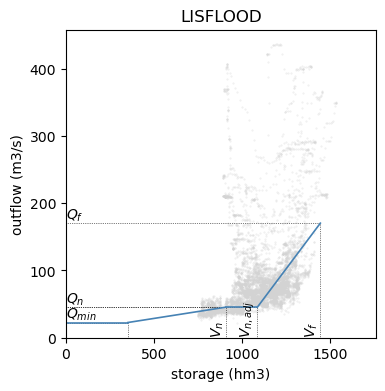

In [80]:
plot_lisflood(lisflood, ts)

***

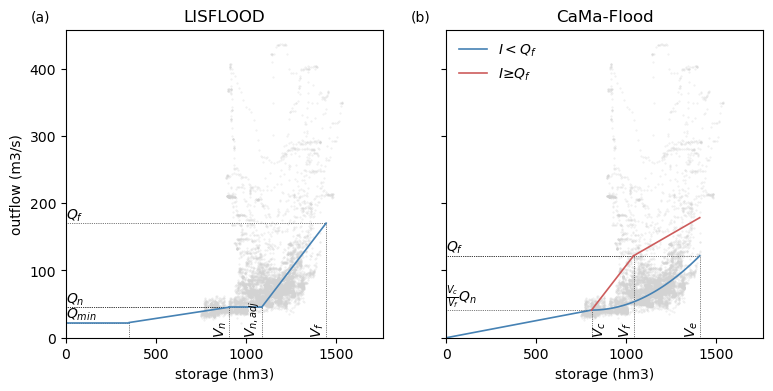

In [82]:
lw = 1.2
c = 'steelblue'

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9, 4), sharex=True, sharey=True)

# LISFLOOD
plot_lisflood(lisflood, ts, ax=ax[0], title='LISFLOOD')
ax[0].text(-0.05, 1.02, '(a)', ha='right', va='bottom', transform=ax[0].transAxes)

# CAMAFLOOD
plot_camaflood(camaflood, ts, ax=ax[1], title='CaMa-Flood', ylabel=None)
ax[1].text(-0.05, 1.02, '(b)', ha='right', va='bottom', transform=ax[1].transAxes)

plt.savefig('lisflood_camaflood.pdf', dpi=300, bbox_inches='tight')
plt.show()